### Instantiate environment

In [38]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

### Read data

In [2]:
train_df = PandasTools.LoadSDF("data/TR_AOH_516.sdf")
test_df = PandasTools.LoadSDF("data/TST_AOH_176.sdf")

### Concatenate data

In [3]:
AOH = pd.concat([train_df[["Canonical_QSARr", "LogOH"]],
                 test_df[["Canonical_QSARr", "LogOH"]]], ignore_index = True)
AOH['LogOH'] = pd.to_numeric(AOH['LogOH'])

### Calculate features

In [4]:
nms = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(nms)
for i in range(len(AOH)):
    descrs = calc.CalcDescriptors(Chem.MolFromSmiles(AOH.iloc[i, 0]))
    for x in range(len(descrs)):
        AOH.at[i, str(nms[x])] = descrs[x]
AOH = AOH.dropna()

AOH.shape

(691, 202)

### Training & Test Datasets

In [5]:
X = AOH.drop(columns=["Canonical_QSARr", "LogOH"])
y = AOH[["LogOH"]]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 350,
                                                    test_size = 0.2)

### Identify / remove near-zero variance descriptors

In [6]:
def variance_threshold_selector(data, threshold = 0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices = True)]]

nzv = variance_threshold_selector(X_train, 0.0)

X_train = X_train[nzv.columns]
X_test = X_test[nzv.columns]

### Identify / remove highly correlated descriptors

In [7]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                  k = 1).astype(np.bool))
to_drop = [column for column in upper.columns
           if any(upper[column] > 0.85)]

X_train = X_train[X_train.columns.drop(to_drop)]
X_test = X_test[X_test.columns.drop(to_drop)]

### standardize features by removing the mean and scaling to unit variance

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

### TPOT

In [9]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2)
tpot.fit(X_train_standard, y_train)
print(tpot.score(X_test_standard, y_test))
tpot.export('tpot_AOH_pipeline.py')

C:\Users\us16120\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\us16120\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


C:\Users\us16120\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: -0.29599259227366875


Generation 2 - Current best internal CV score: -0.2827209524298127


Generation 3 - Current best internal CV score: -0.2540467870299954


Generation 4 - Current best internal CV score: -0.22563162875584739


Generation 5 - Current best internal CV score: -0.22563162875584739


Generation 6 - Current best internal CV score: -0.22563162875584739


Generation 7 - Current best internal CV score: -0.22563162875584739


Generation 8 - Current best internal CV score: -0.22220832148809205


Generation 9 - Current best internal CV score: -0.22220832148809205


Generation 10 - Current best internal CV score: -0.22220832148809205



Best pipeline: GradientBoostingRegressor(LinearSVR(LassoLarsCV(input_matrix, normalize=False), C=15.0, dual=False, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.01), alpha=0.8, learning_rate=0.1, loss=ls, max_depth=10, max_features=0.2, min_samples_leaf=9, min_samples_split=11, n_estimators=100, subsample=0.7500000000000001)
-0.16286415543432833


True

## Use best pipeline 

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator

In [11]:
# Score on the training set was:-0.23600217676872473
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
    StackingEstimator(estimator=LinearSVR(C=15.0, dual=False, epsilon=0.0001, loss="squared_epsilon_insensitive", tol=0.01)),
    GradientBoostingRegressor(alpha=0.8, learning_rate=0.1, loss="ls", max_depth=10, max_features=0.2, min_samples_leaf=9, min_samples_split=11, n_estimators=100, subsample=0.7500000000000001)
)

In [12]:
training_features = X_train_standard
testing_features = X_test_standard
training_target = np.array(y_train['LogOH'])
testing_target =  np.array(y_test['LogOH'])

In [13]:
exported_pipeline.fit(training_features, training_target)

C:\Users\us16120\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Pipeline(memory=None,
     steps=[('stackingestimator-1', StackingEstimator(estimator=LassoLarsCV(copy_X=True, cv='warn', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=None,
      normalize=False, positive=False, precompute='auto', verbose=False))), ('stackingestimator-2', Stacki...0.7500000000000001, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

### Predict test data

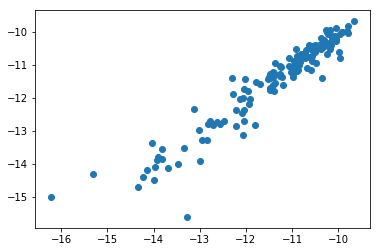

In [40]:
results = exported_pipeline.predict(testing_features)

obs = np.array(y_test["LogOH"])
import matplotlib.pyplot as plt
plt.scatter(obs, results)
plt.show()

In [41]:
pearsonr(obs, results)

(0.9536065226337151, 2.677612567133776e-73)

### Predict training data

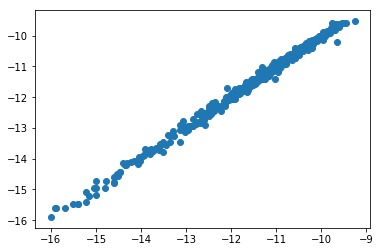

In [35]:
results = exported_pipeline.predict(training_features)

obs = np.array(y_train["LogOH"])
import matplotlib.pyplot as plt
plt.scatter(obs, results)
plt.show()

In [39]:
pearsonr(obs, results)

(0.9975984325601716, 0.0)